<a href="https://colab.research.google.com/github/LCRazo/GPU-Utilization-and-Improvement-Project-/blob/main/BatchIncrease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Background

Below are the runnable codes to test GPU and GPU + Mixed Precision usage, as well as training times for GPU, GPU + Mixed Precision, and CPU. Change the runtime depending on what block you're running. Below are screenshots of what the program was being run on, the batch size, what factor the original batch was increased by, and the time it took to train. **GPU blocks here were run on the T4 GPU

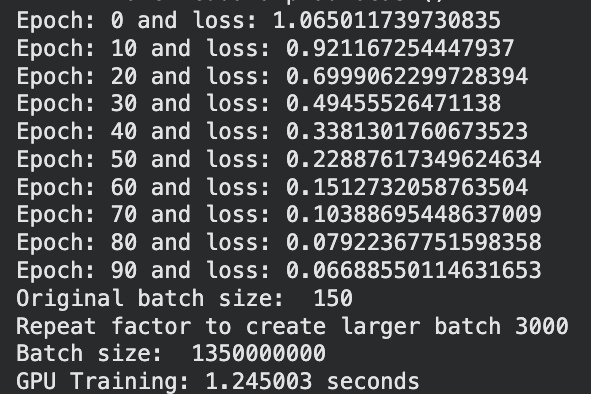
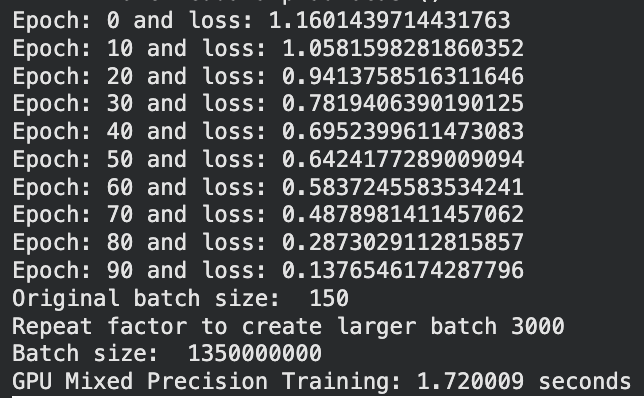

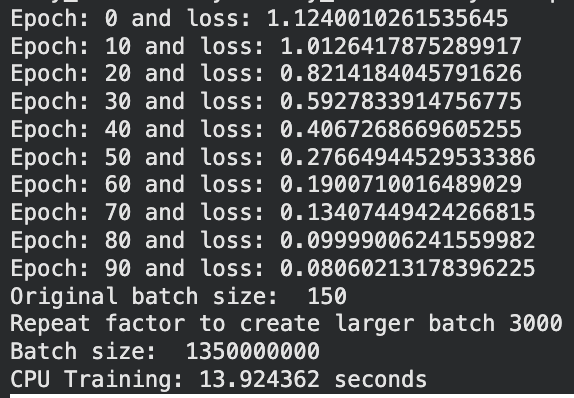

#GPU Mixed Precision

True
1
Current device: 0
Device name: Tesla T4


/tmp/ipython-input-452219625.py:56: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  my_df['variety'] = my_df['variety'].replace('Virginica', 2.0)
/tmp/ipython-input-452219625.py:86: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/tmp/ipython-input-452219625.py:107: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch: 0 and loss: 1.1601439714431763
Epoch: 10 and loss: 1.0581598281860352
Epoch: 20 and loss: 0.9413758516311646
Epoch: 30 and loss: 0.7819406390190125
Epoch: 40 and loss: 0.6952399611473083
Epoch: 50 and loss: 0.6424177289009094
Epoch: 60 and loss: 0.5837245583534241
Epoch: 70 and loss: 0.4878981411457062
Epoch: 80 and loss: 0.2873029112815857
Epoch: 90 and loss: 0.1376546174287796
Original batch size:  150
Repeat factor to create larger batch 3000
Batch size:  1350000000
GPU Mixed Precision Training: 1.720009 seconds


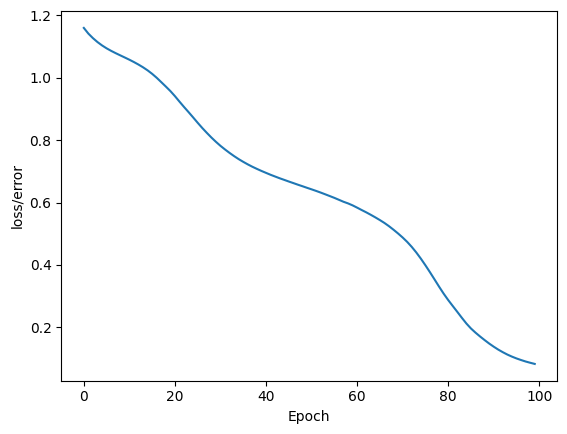

Streaming output truncated to the last 5000 lines.
85035.)  tensor([-9.0082,  4.3365,  9.1022], device='cuda:0') 	 2 	 2
85036.)  tensor([-8.8512,  3.8131,  9.5604], device='cuda:0') 	 2 	 2
85037.)  tensor([-5.2771,  3.6356,  3.9039], device='cuda:0') 	 1 	 2
85038.)  tensor([-8.3865,  4.0755,  8.4453], device='cuda:0') 	 2 	 2
85039.)  tensor([-2.4112,  3.4035, -0.5554], device='cuda:0') 	 1 	 1
85040.)  tensor([-3.8380,  3.8950,  1.1648], device='cuda:0') 	 1 	 1
85041.)  tensor([-3.7570,  3.7589,  1.1923], device='cuda:0') 	 1 	 1
85042.)  tensor([-9.0082,  4.3365,  9.1022], device='cuda:0') 	 2 	 2
85043.)  tensor([-2.5533,  3.4214, -0.3372], device='cuda:0') 	 1 	 1
85044.)  tensor([-0.9009,  2.5258, -2.4150], device='cuda:0') 	 1 	 1
85045.)  tensor([-6.8364,  3.7824,  6.2928], device='cuda:0') 	 2 	 2
85046.)  tensor([ 2.6859, -1.3245, -7.3982], device='cuda:0') 	 0 	 0
85047.)  tensor([-4.6372,  3.5359,  2.9512], device='cuda:0') 	 1 	 1
85048.)  tensor([-3.0537,  3.2386,  0.7

' # Returns the maximum GPU memory (in bytes) that was ever allocated during the current session\n        print(f"Max memory allocated: {torch.cuda.max_memory_allocated() / (1024**2):.2f} MB")\n        # Returns the maximum GPU memory (in bytes) that was ever cached during the current session\n        print(f"Max memory cached: {torch.cuda.max_memory_reserved() / (1024**2):.2f} MB") '

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
# Mixed precision imports
from torch.cuda.amp import autocast, GradScaler
from sklearn.model_selection import train_test_split
# %matplotlib inline

# Create a Model Class that inherits nn.Module
class Model(nn.Module):
  # Input layer (4 features of the flower) -->
  # Hidden Layer1 (number of neurons) -->
  # H2 (n) -->
  # output (3 classes of iris flowers)
  def __init__(self, in_features=4, h1=8, h2=9, out_features=3):
    super().__init__() # instantiate our nn.Module
    self.fc1 = nn.Linear(in_features, h1).cuda(0)
    self.fc2 = nn.Linear(h1, h2).cuda(0)
    self.out = nn.Linear(h2, out_features).cuda(0)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.out(x)

    return x

print(torch.cuda.is_available()) # This tells me if CUDA-enabled GPU is detected and PyTorch is configured to use it
print(torch.cuda.device_count()) # Returns the available GPUs

if torch.cuda.is_available():
  print(f"Current device: {torch.cuda.current_device()}")
  print(f"Device name: {torch.cuda.get_device_name(0)}")

  # print(stats)

  # main code
  # Pick a manual seed for randomization
  torch.cuda.manual_seed(41)
  # Create an instance of model
  model = Model().cuda(0)

  url = 'https://gist.githubusercontent.com/netj/8836201/raw/6f9306ad21398ea43cba4f7d537619d0e07d5ae3/iris.csv'
  my_df = pd.read_csv(url)


  my_df.tail() # This will display the last 5 rows

  # Change last column from strings to integers
  my_df['variety'] = my_df['variety'].replace('Setosa', 0.0)
  my_df['variety'] = my_df['variety'].replace('Versicolor', 1.0)
  my_df['variety'] = my_df['variety'].replace('Virginica', 2.0)

  # Train Test Split!  Set X, y
  X = my_df.drop('variety', axis=1)
  y = my_df['variety']

  # Convert these to numpy arrays
  X = X.values
  y = y.values


  #To increase batch
  repeat_factor = 3000
  X = np.tile(X, (repeat_factor, 1))
  y = np.tile(y, repeat_factor)

  # Train Test Split
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=41)

  # Convert X features to float tensors
  X_train = torch.FloatTensor(X_train).cuda(0)
  X_test = torch.FloatTensor(X_test).cuda(0)

  # Convert y labels to tensors long
  y_train = torch.LongTensor(y_train).cuda(0)
  y_test = torch.LongTensor(y_test).cuda(0)

  # Set the criterion of model to measure the error, how far off the predictions are from the data
  criterion = nn.CrossEntropyLoss().cuda(0)
  # Choose Adam Optimizer, lr = learning rate (if error doesn't go down after a bunch of iterations (epochs), lower our learning rate)
  scaler = GradScaler()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

  # Train our model!
  # Epochs? (one run thru all the training data in our network)
  epochs = 100
  losses = []

#to time
  torch.cuda.synchronize()
  start = time.time()
################

  for i in range(epochs):
    # Go forward and get a prediction
    # y_pred = model.forward(X_train) # Get predicted results

    # Measure the loss/error, gonna be high at first
    # loss = criterion(y_pred, y_train) # predicted values vs the y_train

    # This is for mixed precision
    with torch.cuda.amp.autocast():
      # Go forward and get a prediction
      y_pred = model.forward(X_train) # Get predicted results
      # Measure the loss/error, gonna be high at first
      loss = criterion(y_pred, y_train) # predicted values vs the y_train

      # Keep Track of our losses
      lossCPU = loss.cpu()
      losses.append(lossCPU.detach().numpy())

    # print every 10 epoch
    if i % 10 == 0:
      print(f'Epoch: {i} and loss: {loss}')

    # Do some back propagation: take the error rate of forward propagation and feed it back
    # thru the network to fine tune the weights
    # Backpropagation with mixed precision
    optimizer.zero_grad()
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()

  ########PRINT TIME
  torch.cuda.synchronize()
  end = time.time()
  print(f"Original batch size: ", my_df.shape[0])
  print(f"Repeat factor to create larger batch", repeat_factor)
  print(f"Batch size: ", repeat_factor * X.shape[0])
  print(f"GPU Mixed Precision Training: {end - start:.6f} seconds")

  stats = torch.cuda.memory_stats()

  # Graph it out!
  plt.plot(range(epochs), losses)
  plt.ylabel("loss/error")
  plt.xlabel('Epoch')
  plt.show()

  # Evaluate Model on Test Data Set (validate model on test set)
  with torch.no_grad():  # Basically turn off back propogation
    y_eval = model.forward(X_test) # X_test are features from our test set, y_eval will be predictions
    loss = criterion(y_eval, y_test) # Find the loss or error

  correct = 0
  with torch.no_grad():
    for i, data in enumerate(X_test):
      y_val = model.forward(data)

      if y_test[i] == 0:
        x = "Setosa"
      elif y_test[i] == 1:
        x = 'Versicolor'
      else:
        x = 'Virginica'


      # Will tell us what type of flower class our network thinks it is
      print(f'{i+1}.)  {str(y_val)} \t {y_test[i]} \t {y_val.argmax().item()}')

      # Correct or not
      if y_val.argmax().item() == y_test[i]:
        correct +=1

  print(f'We got {correct} correct!')

  stats = torch.cuda.memory_stats()
  # Get current allocated memory
  allocated_memory = torch.cuda.memory_allocated(0)
  print(f"Current allocated memory: {allocated_memory / (1024**2):.2f} MB")

  # Get reserved memory
  reserved_memory = torch.cuda.memory_reserved(0)
  print(f"Reserved memory: {reserved_memory / (1024**2):.2f} MB")

  # Get peak allocated memory
  peak_allocated_memory = torch.cuda.max_memory_allocated(0)
  print(f"Peak allocated memory: {peak_allocated_memory / (1024**2):.2f} MB")
  print(torch.cuda.memory_summary(device=0, abbreviated=True))

  """ new_iris = torch.tensor([4.7, 3.2, 1.3, 0.2])
        with torch.no_grad():
          print(model(new_iris))

        newer_iris = torch.tensor([5.9, 3.0, 5.1, 1.8])

        with torch.no_grad():
          print(model(newer_iris))

        # Save our NN Model
        torch.save(model.state_dict(), 'my_really_awesome_iris_model.pt')

        # Load the Saved Model
        new_model = Model()
        new_model.load_state_dict(torch.load('my_really_awesome_iris_model.pt'))

        # Make sure it loaded correctly
        new_model.eval() """
        # end main code


""" # Returns the maximum GPU memory (in bytes) that was ever allocated during the current session
        print(f"Max memory allocated: {torch.cuda.max_memory_allocated() / (1024**2):.2f} MB")
        # Returns the maximum GPU memory (in bytes) that was ever cached during the current session
        print(f"Max memory cached: {torch.cuda.max_memory_reserved() / (1024**2):.2f} MB") """

#GPU BLOCK

True
1
Current device: 0
Device name: Tesla T4


/tmp/ipython-input-2161459455.py:56: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  my_df['variety'] = my_df['variety'].replace('Virginica', 2.0)
/tmp/ipython-input-2161459455.py:87: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/tmp/ipython-input-2161459455.py:108: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch: 0 and loss: 1.065011739730835
Epoch: 10 and loss: 0.921167254447937
Epoch: 20 and loss: 0.6999062299728394
Epoch: 30 and loss: 0.49455526471138
Epoch: 40 and loss: 0.3381301760673523
Epoch: 50 and loss: 0.22887617349624634
Epoch: 60 and loss: 0.1512732058763504
Epoch: 70 and loss: 0.10388695448637009
Epoch: 80 and loss: 0.07922367751598358
Epoch: 90 and loss: 0.06688550114631653
Original batch size:  150
Repeat factor to create larger batch 3000
Batch size:  1350000000
GPU Training: 1.245003 seconds


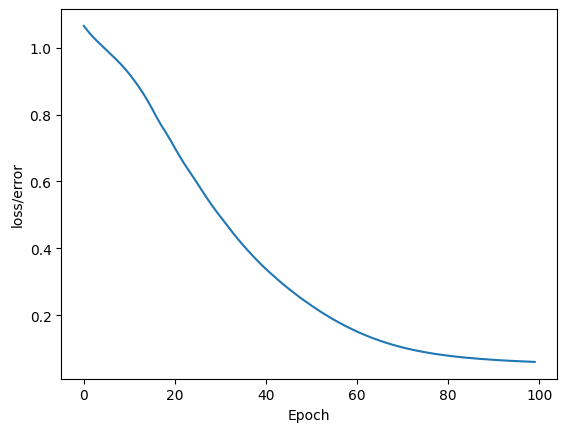

Streaming output truncated to the last 5000 lines.
85035.)  tensor([-5.5744,  3.2717,  9.1386], device='cuda:0') 	 2 	 2
85036.)  tensor([-5.7271,  2.2460,  9.9168], device='cuda:0') 	 2 	 2
85037.)  tensor([-2.8791,  4.3315,  3.6705], device='cuda:0') 	 1 	 1
85038.)  tensor([-5.1868,  3.1534,  8.4837], device='cuda:0') 	 2 	 2
85039.)  tensor([-1.1529,  5.1790,  0.0868], device='cuda:0') 	 1 	 1
85040.)  tensor([-1.8173,  5.5589,  1.1235], device='cuda:0') 	 1 	 1
85041.)  tensor([-1.9347,  5.1862,  1.5202], device='cuda:0') 	 1 	 1
85042.)  tensor([-5.5744,  3.2717,  9.1386], device='cuda:0') 	 2 	 2
85043.)  tensor([-1.2599,  5.1184,  0.3128], device='cuda:0') 	 1 	 1
85044.)  tensor([ 0.4420,  4.5571, -2.2215], device='cuda:0') 	 1 	 1
85045.)  tensor([-4.1847,  3.4418,  6.5019], device='cuda:0') 	 2 	 2
85046.)  tensor([  7.1163,   1.7258, -10.6595], device='cuda:0') 	 0 	 0
85047.)  tensor([-2.4533,  4.5053,  2.8037], device='cuda:0') 	 1 	 1
85048.)  tensor([-1.5146,  4.7007,  

' # Returns the maximum GPU memory (in bytes) that was ever allocated during the current session\n        print(f"Max memory allocated: {torch.cuda.max_memory_allocated() / (1024**2):.2f} MB")\n        # Returns the maximum GPU memory (in bytes) that was ever cached during the current session\n        print(f"Max memory cached: {torch.cuda.max_memory_reserved() / (1024**2):.2f} MB") '

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
# Mixed precision imports
from torch.cuda.amp import autocast, GradScaler
from sklearn.model_selection import train_test_split
# %matplotlib inline

# Create a Model Class that inherits nn.Module
class Model(nn.Module):
  # Input layer (4 features of the flower) -->
  # Hidden Layer1 (number of neurons) -->
  # H2 (n) -->
  # output (3 classes of iris flowers)
  def __init__(self, in_features=4, h1=8, h2=9, out_features=3):
    super().__init__() # instantiate our nn.Module
    self.fc1 = nn.Linear(in_features, h1).cuda(0)
    self.fc2 = nn.Linear(h1, h2).cuda(0)
    self.out = nn.Linear(h2, out_features).cuda(0)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.out(x)

    return x

print(torch.cuda.is_available()) # This tells me if CUDA-enabled GPU is detected and PyTorch is configured to use it
print(torch.cuda.device_count()) # Returns the available GPUs

if torch.cuda.is_available():
  print(f"Current device: {torch.cuda.current_device()}")
  print(f"Device name: {torch.cuda.get_device_name(0)}")

  # print(stats)

  # main code
  # Pick a manual seed for randomization
  torch.cuda.manual_seed(41)
  # Create an instance of model
  model = Model().cuda(0)

  url = 'https://gist.githubusercontent.com/netj/8836201/raw/6f9306ad21398ea43cba4f7d537619d0e07d5ae3/iris.csv'
  my_df = pd.read_csv(url)


  my_df.tail() # This will display the last 5 rows

  # Change last column from strings to integers
  my_df['variety'] = my_df['variety'].replace('Setosa', 0.0)
  my_df['variety'] = my_df['variety'].replace('Versicolor', 1.0)
  my_df['variety'] = my_df['variety'].replace('Virginica', 2.0)

  # Train Test Split!  Set X, y
  X = my_df.drop('variety', axis=1)
  y = my_df['variety']

  # Convert these to numpy arrays
  X = X.values
  y = y.values

  #TO REPEAT BATCH
  # Repeat the dataset 1000× to increase size from 150 → 150,000
  repeat_factor = 3000
  X = np.tile(X, (repeat_factor, 1))   # shape becomes (150000, 4)
  y = np.tile(y, repeat_factor)        # shape becomes (150000,)


  # Train Test Split
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=41)

  # Convert X features to float tensors
  X_train = torch.FloatTensor(X_train).cuda(0)
  X_test = torch.FloatTensor(X_test).cuda(0)

  # Convert y labels to tensors long
  y_train = torch.LongTensor(y_train).cuda(0)
  y_test = torch.LongTensor(y_test).cuda(0)

  # Set the criterion of model to measure the error, how far off the predictions are from the data
  criterion = nn.CrossEntropyLoss().cuda(0)
  # Choose Adam Optimizer, lr = learning rate (if error doesn't go down after a bunch of iterations (epochs), lower our learning rate)
  scaler = GradScaler()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

  # Train our model!
  # Epochs? (one run thru all the training data in our network)
  epochs = 100
  losses = []

#ADDED TO TIME
  torch.cuda.synchronize()
  start = time.time()
################

  for i in range(epochs):
    # Go forward and get a prediction
    # y_pred = model.forward(X_train) # Get predicted results

    # Measure the loss/error, gonna be high at first
    # loss = criterion(y_pred, y_train) # predicted values vs the y_train

    # This is for mixed precision
    with torch.cuda.amp.autocast():
      # Go forward and get a prediction
      y_pred = model.forward(X_train) # Get predicted results
      # Measure the loss/error, gonna be high at first
      loss = criterion(y_pred, y_train) # predicted values vs the y_train

      # Keep Track of our losses
      lossCPU = loss.cpu()
      losses.append(lossCPU.detach().numpy())

    # print every 10 epoch
    if i % 10 == 0:
      print(f'Epoch: {i} and loss: {loss}')

    # Do some back propagation: take the error rate of forward propagation and feed it back
    # thru the network to fine tune the weights
    # Backpropagation with mixed precision
    optimizer.zero_grad()
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()

  ########PRINT TIME
  torch.cuda.synchronize()
  end = time.time()
  print(f"Original batch size: ", my_df.shape[0])
  print(f"Repeat factor to create larger batch", repeat_factor)
  print(f"Batch size: ", repeat_factor * X.shape[0])
  print(f"GPU Training: {end - start:.6f} seconds")


  stats = torch.cuda.memory_stats()

  # Graph it out!
  plt.plot(range(epochs), losses)
  plt.ylabel("loss/error")
  plt.xlabel('Epoch')
  plt.show()

  # Evaluate Model on Test Data Set (validate model on test set)
  with torch.no_grad():  # Basically turn off back propogation
    y_eval = model.forward(X_test) # X_test are features from our test set, y_eval will be predictions
    loss = criterion(y_eval, y_test) # Find the loss or error

  correct = 0
  with torch.no_grad():
    for i, data in enumerate(X_test):
      y_val = model.forward(data)

      if y_test[i] == 0:
        x = "Setosa"
      elif y_test[i] == 1:
        x = 'Versicolor'
      else:
        x = 'Virginica'


      # Will tell us what type of flower class our network thinks it is
      print(f'{i+1}.)  {str(y_val)} \t {y_test[i]} \t {y_val.argmax().item()}')

      # Correct or not
      if y_val.argmax().item() == y_test[i]:
        correct +=1

  print(f'We got {correct} correct!')

  stats = torch.cuda.memory_stats()
  # Get current allocated memory
  allocated_memory = torch.cuda.memory_allocated(0)
  print(f"Current allocated memory: {allocated_memory / (1024**2):.2f} MB")

  # Get reserved memory
  reserved_memory = torch.cuda.memory_reserved(0)
  print(f"Reserved memory: {reserved_memory / (1024**2):.2f} MB")

  # Get peak allocated memory
  peak_allocated_memory = torch.cuda.max_memory_allocated(0)
  print(f"Peak allocated memory: {peak_allocated_memory / (1024**2):.2f} MB")
  print(torch.cuda.memory_summary(device=0, abbreviated=True))

  """ new_iris = torch.tensor([4.7, 3.2, 1.3, 0.2])
        with torch.no_grad():
          print(model(new_iris))

        newer_iris = torch.tensor([5.9, 3.0, 5.1, 1.8])

        with torch.no_grad():
          print(model(newer_iris))

        # Save our NN Model
        torch.save(model.state_dict(), 'my_really_awesome_iris_model.pt')

        # Load the Saved Model
        new_model = Model()
        new_model.load_state_dict(torch.load('my_really_awesome_iris_model.pt'))

        # Make sure it loaded correctly
        new_model.eval() """
        # end main code


""" # Returns the maximum GPU memory (in bytes) that was ever allocated during the current session
        print(f"Max memory allocated: {torch.cuda.max_memory_allocated() / (1024**2):.2f} MB")
        # Returns the maximum GPU memory (in bytes) that was ever cached during the current session
        print(f"Max memory cached: {torch.cuda.max_memory_reserved() / (1024**2):.2f} MB") """

#CPU BLOCK

/tmp/ipython-input-3809406257.py:46: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  my_df['variety'] = my_df['variety'].replace('Virginica', 2.0)


Epoch: 0 and loss: 1.1240010261535645
Epoch: 10 and loss: 1.0126417875289917
Epoch: 20 and loss: 0.8214184045791626
Epoch: 30 and loss: 0.5927833914756775
Epoch: 40 and loss: 0.4067268669605255
Epoch: 50 and loss: 0.27664944529533386
Epoch: 60 and loss: 0.1900710016489029
Epoch: 70 and loss: 0.13407449424266815
Epoch: 80 and loss: 0.09999006241559982
Epoch: 90 and loss: 0.08060213178396225
Original batch size:  150
Repeat factor to create larger batch 3000
Batch size:  1350000000
CPU Training: 13.924362 seconds


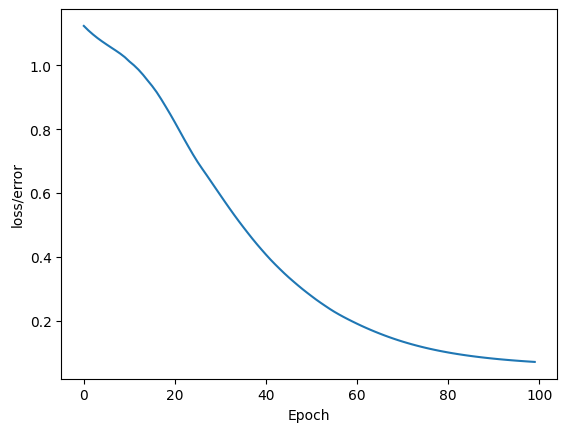

Streaming output truncated to the last 5000 lines.
85005.)  tensor([-8.2421,  4.3661, 10.3254]) 	 2 	 2
85006.)  tensor([-5.2456,  5.0740,  4.4413]) 	 1 	 1
85007.)  tensor([-2.6774,  4.5524,  0.7655]) 	 1 	 1
85008.)  tensor([-8.1723,  4.3863, 10.1951]) 	 2 	 2
85009.)  tensor([ 4.9401, -2.5775, -3.0877]) 	 0 	 0
85010.)  tensor([-7.5665,  4.3329,  9.2363]) 	 2 	 2
85011.)  tensor([ 4.9739, -2.6088, -3.1027]) 	 0 	 0
85012.)  tensor([-3.9976,  5.8674,  1.4564]) 	 1 	 1
85013.)  tensor([-8.0598,  4.4143,  9.9595]) 	 2 	 2
85014.)  tensor([ 4.6665, -2.3325, -2.9610]) 	 0 	 0
85015.)  tensor([-6.6267,  4.7221,  7.2065]) 	 2 	 2
85016.)  tensor([ 4.1415, -1.8573, -2.7213]) 	 0 	 0
85017.)  tensor([ 4.5671, -2.2536, -2.9082]) 	 0 	 0
85018.)  tensor([-6.6196,  4.5722,  7.3399]) 	 2 	 2
85019.)  tensor([-8.9158,  4.6322, 11.1868]) 	 2 	 2
85020.)  tensor([-2.0489,  3.9321,  0.4367]) 	 1 	 1
85021.)  tensor([-6.5320,  4.6775,  7.1001]) 	 2 	 2
85022.)  tensor([-6.5320,  4.6775,  7.1001]) 	 2

' # Returns the maximum GPU memory (in bytes) that was ever allocated during the current session\n        print(f"Max memory allocated: {torch.cuda.max_memory_allocated() / (1024**2):.2f} MB")\n        # Returns the maximum GPU memory (in bytes) that was ever cached during the current session\n        print(f"Max memory cached: {torch.cuda.max_memory_reserved() / (1024**2):.2f} MB") '

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import time
# %matplotlib inline

# Create a Model Class that inherits nn.Module
class Model(nn.Module):
  # Input layer (4 features of the flower) -->
  # Hidden Layer1 (number of neurons) -->
  # H2 (n) -->
  # output (3 classes of iris flowers)
  def __init__(self, in_features=4, h1=8, h2=9, out_features=3):
    super().__init__() # instantiate our nn.Module
    self.fc1 = nn.Linear(in_features, h1)
    self.fc2 = nn.Linear(h1, h2)
    self.out = nn.Linear(h2, out_features)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.out(x)

    return x


# main code
# Pick a manual seed for randomization
torch.manual_seed(41)
# Create an instance of model
model = Model()

url = 'https://gist.githubusercontent.com/netj/8836201/raw/6f9306ad21398ea43cba4f7d537619d0e07d5ae3/iris.csv'
my_df = pd.read_csv(url)


my_df.tail() # This will display the last 5 rows

# Change last column from strings to integers
my_df['variety'] = my_df['variety'].replace('Setosa', 0.0)
my_df['variety'] = my_df['variety'].replace('Versicolor', 1.0)
my_df['variety'] = my_df['variety'].replace('Virginica', 2.0)

# Train Test Split!  Set X, y
X = my_df.drop('variety', axis=1)
y = my_df['variety']

# Convert these to numpy arrays
X = X.values
y = y.values

#TO REPEAT BATCH
# Repeat the dataset 1000× to increase size from 150 → 150,000
repeat_factor = 3000
X = np.tile(X, (repeat_factor, 1))   # shape becomes (150000, 4)
y = np.tile(y, repeat_factor)        # shape becomes (150000,)

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=41)

# Convert X features to float tensors
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)

# Convert y labels to tensors long
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

# Set the criterion of model to measure the error, how far off the predictions are from the data
criterion = nn.CrossEntropyLoss()
# Choose Adam Optimizer, lr = learning rate (if error doesn't go down after a bunch of iterations (epochs), lower our learning rate)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Train our model!
# Epochs? (one run thru all the training data in our network)
epochs = 100
losses = []

#TO TIME
start = time.time()
#########

for i in range(epochs):
  # Go forward and get a prediction
  y_pred = model.forward(X_train) # Get predicted results

  # Measure the loss/error, gonna be high at first
  loss = criterion(y_pred, y_train) # predicted values vs the y_train

  # Keep Track of our losses

  losses.append(loss.detach().numpy())

  # print every 10 epoch
  if i % 10 == 0:
    print(f'Epoch: {i} and loss: {loss}')

  # Do some back propagation: take the error rate of forward propagation and feed it back
  # thru the network to fine tune the weights
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

#PRINT TIME
end = time.time()
print(f"Original batch size: ", my_df.shape[0])
print(f"Repeat factor to create larger batch", repeat_factor)
print(f"Batch size: ", repeat_factor * X.shape[0])
print(f"CPU Training: {end - start:.6f} seconds")


        # Graph it out!
plt.plot(range(epochs), losses)
plt.ylabel("loss/error")
plt.xlabel('Epoch')
plt.show()

# Evaluate Model on Test Data Set (validate model on test set)
with torch.no_grad():  # Basically turn off back propogation
  y_eval = model.forward(X_test) # X_test are features from our test set, y_eval will be predictions
  loss = criterion(y_eval, y_test) # Find the loss or error

correct = 0
with torch.no_grad():
  for i, data in enumerate(X_test):
    y_val = model.forward(data)

    if y_test[i] == 0:
      x = "Setosa"
    elif y_test[i] == 1:
      x = 'Versicolor'
    else:
      x = 'Virginica'


    # Will tell us what type of flower class our network thinks it is
    print(f'{i+1}.)  {str(y_val)} \t {y_test[i]} \t {y_val.argmax().item()}')

    # Correct or not
    if y_val.argmax().item() == y_test[i]:
      correct +=1

print(f'We got {correct} correct!')

# Get current allocated memory
allocated_memory = torch.cuda.memory_allocated(0)
print(f"Current allocated memory: {allocated_memory / (1024**2):.2f} MB")

# Get reserved memory
reserved_memory = torch.cuda.memory_reserved(0)
print(f"Reserved memory: {reserved_memory / (1024**2):.2f} MB")

# Get peak allocated memory
peak_allocated_memory = torch.cuda.max_memory_allocated(0)
print(f"Peak allocated memory: {peak_allocated_memory / (1024**2):.2f} MB")
# print(torch.cuda.memory_summary(device=0, abbreviated=True))

""" new_iris = torch.tensor([4.7, 3.2, 1.3, 0.2])
      with torch.no_grad():
        print(model(new_iris))

    newer_iris = torch.tensor([5.9, 3.0, 5.1, 1.8])

    with torch.no_grad():
      print(model(newer_iris))

    # Save our NN Model
    torch.save(model.state_dict(), 'my_really_awesome_iris_model.pt')

    # Load the Saved Model
    new_model = Model()
    new_model.load_state_dict(torch.load('my_really_awesome_iris_model.pt'))

    # Make sure it loaded correctly
    new_model.eval() """
    # end main code


""" # Returns the maximum GPU memory (in bytes) that was ever allocated during the current session
        print(f"Max memory allocated: {torch.cuda.max_memory_allocated() / (1024**2):.2f} MB")
        # Returns the maximum GPU memory (in bytes) that was ever cached during the current session
        print(f"Max memory cached: {torch.cuda.max_memory_reserved() / (1024**2):.2f} MB") """



#Shape Tests + Miscellaneous

In [2]:
X.shape

(450000, 4)

In [3]:
my_df.shape

(150, 5)

In [4]:
X_train.shape

torch.Size([360000, 4])

In [5]:
X_test.shape

torch.Size([90000, 4])

In [8]:
repeat_factor * X.shape[0]

3750000000